## VAE example
Follow the tutorial on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial which is for MNIST data; then adapt to FashionMNIST and CIFAR10 (for the latter optimization was slow and noisy).

In [1]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import time


In [2]:
dataset_path = '~/datasets'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load or download dataset

In [632]:
# options: MNIST, FashionMNIST, CIFAR10
data_set = "FashionMNIST"

In [633]:
batch_size = 10000 # NOTE: use 10000 for MNIST and FashionMNIST

if (data_set == "MNIST"):
    x_dim = 784
    hidden_dim = 400
    latent_dim = 200

if (data_set == "CIFAR10"):
    x_dim = 32 * 32 * 3  # 3 color channels...
    hidden_dim = 128
    latent_dim = 100


if (data_set == "FashionMNIST"):
    x_dim = 28 * 28
    # hidden_dim and latent_dim are specified later.


In [634]:
if (data_set == "MNIST"):
        from torchvision.datasets import MNIST
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader

        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

if (data_set == "CIFAR10"):
        from torchvision.datasets import CIFAR10
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader


        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)


if (data_set == "FashionMNIST"):
        from torchvision.datasets import FashionMNIST
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader


        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = FashionMNIST(dataset_path, transform=mnist_transform, train=False, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)


## Define target distribution and a variational family

In [635]:
use_bias = True
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim, bias = use_bias)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim, bias = use_bias)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim, bias = use_bias)
        self.FC_sd_log = nn.Linear(hidden_dim, latent_dim, bias = use_bias)

        self.LeakyRelu = nn.LeakyReLU(0.2)

        self.training = False  # CHECK -- what does this line do?

    def forward(self, x):
        h_ = self.LeakyRelu(self.FC_input(x))
        h_ = self.LeakyRelu(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        sd_log = self.FC_sd_log(h_)

        return mean, sd_log


In [636]:
def init_encoder(encoder, z_dim, hidden_dim, x_dim, nu_mean_z, nu_sd_z_log):
    # Initialize A-VI at the output of a constant inference network.
    encoder.FC_input.weights = nn.Parameter(torch.zeros(hidden_dim, x_dim)).to(device)
    encoder.FC_input2.weights = nn.Parameter(torch.zeros(hidden_dim, hidden_dim)).to(device)
    encoder.FC_mean.weights = nn.Parameter(torch.zeros(z_dim, hidden_dim)).to(device)
    encoder.FC_sd_log.weights = nn.Parameter(torch.zeros(z_dim, hidden_dim)).to(device)
    encoder.FC_mean.bias = nn.Parameter(nu_mean_z)
    encoder.FC_sd_log.bias = nn.Parameter(nu_sd_z_log)

    return encoder


In [639]:
def likelihood_NN(theta, z, latent_dim, hidden_dim, x_dim):
    index_layer1 = latent_dim * hidden_dim
    index_layer2 = index_layer1 + hidden_dim**2
    index_out = index_layer2 + hidden_dim * x_dim
    index_bias1 = index_out + hidden_dim
    index_bias2 = index_bias1 + hidden_dim

    # weights
    W1 = theta[:index_layer1].reshape((hidden_dim, latent_dim))    
    W2 = theta[index_layer1:index_layer2].reshape((hidden_dim, hidden_dim))   
    W3 = theta[index_layer2:index_out].reshape((x_dim, hidden_dim))

    # bias
    b1 = theta[index_out:index_bias1].reshape((hidden_dim))
    b2 = theta[index_bias1:index_bias2].reshape((hidden_dim))
    b3 = theta[index_bias2:].reshape((x_dim))

    LeakyRelu = nn.LeakyReLU(0.2)
    h = LeakyRelu(torch.matmul(z, torch.t(W1)) + b1)
    h = LeakyRelu(torch.matmul(h, torch.t(W2)) + b2)
    out = torch.matmul(h, torch.t(W3)) + b3

    return out

In [641]:

def set_weights_R(decoder, theta, latent_dim, hidden_dim, x_dim):
    """
    A utility function to pass theta to a neural network. The weights are stored in theta 
    in vector form and need to be unpacked.
    """
    # Set weights
    index_layer1 = latent_dim * hidden_dim
    decoder.FC_hidden.weight =\
        nn.Parameter(theta[:index_layer1].reshape((hidden_dim, latent_dim)))
    
    index_layer2 = index_layer1 + hidden_dim**2
    decoder.FC_hidden2.weight =\
        nn.Parameter(theta[index_layer1:index_layer2].reshape((hidden_dim, hidden_dim)))
    
    index_mu = index_layer2 + hidden_dim * x_dim
    decoder.FC_mu.weight =\
            nn.Parameter(theta[index_layer2:index_mu].reshape((x_dim, hidden_dim)))
    
    # Set biases
    index_bias1 = index_mu + hidden_dim
    decoder.FC_hidden.bias = nn.Parameter(theta[index_mu:index_bias1].reshape((hidden_dim)))

    index_bias2 = index_bias1 + hidden_dim
    decoder.FC_hidden.bias = nn.Parameter(theta[index_bias1:index_bias2].reshape((hidden_dim)))

    decoder.FC_mu.bias = nn.Parameter(theta[index_bias2:].reshape((x_dim)))

    return decoder 


In [642]:
# NOTE: pytorch distributions don't seem to work on cudas
def bernoulli_lpmf(x, p):
    eps = 1e-10
    return torch.sum(x * torch.log(p + eps) + (1 - x) * torch.log(1 - p + eps),
                                  dim = (1, 2))

def gaussian_lpdf(x, mu, sigma_2):
    # return torch.sum( - 0.5 * torch.log(sigma_2) - 1 / (2 * sigma_2) * (x - mu)**2)
    return - 0.5 * torch.sum((x - mu)**2)


In [643]:
# Vectorized for GPU (the first index corresponds to the Monte Carlo sample).
# ToDo: add implementation for data subsetting.
def log_joint_MNIST(x, p, z, theta):
    """
    Compute the log joint (log prior + log likelihood) for the MNIST data set.
    The prior on z and theta are standard Gaussians, and the likelihood is Bernoulli.
    x: observation
    p: parameter of likelihood (usually output of a neural network)
    z: latent variable
    theta: weight of the neural network.
    """
    eps = 1e-10  # add jitter to stabilize cases where p is close to 0 or 1
    like_weight = z.size()[1] / x.size()[0]
    
    return -0.5 * torch.sum(z**2, dim = (1, 2))\
           -0.5 * torch.sum(theta**2, dim = 1)\
        + like_weight * bernoulli_lpmf(x, p)

def log_joint_R(x, mu, sigma, z, theta):
    """
    Compute the log joint (log prior + log likelihood).
    The prior on z and theta are standard Gaussians, and the likelihood is a Gaussian.
    x: observation
    mu: likelihood mean (usually output of a neural network)
    sigma: likelihood standard deviation (fixed or output of a neural network)
    z: latent variable
    theta: neural network weights
    """
    like_weight = z.size()[0] / x.size()[0]  # n_obs / batch_size = num_batches
    return -0.5 * torch.sum(z**2) - like_weight * torch.sum((x - mu)**2) - torch.sum(theta**2)
          # -0.5 * torch.sum(theta**2, dim = 1)\

        

def log_q(theta, z, nu_mean_theta, nu_sd_theta_2, nu_mean_z, nu_sd_z_2):
  """
  Evaluate the log density for the (Gaussian) variational approximation.
  theta: neural network weight
  z: latent variable
  nu_mean_theta: variational mean for theta.
  nu_sd_theta: variational variance for theta.
  nu_mean_z: variational mean for z.
  nu_sd_z_2: variational variance for z.
  """
  log_q_theta = torch.sum(- 0.5 * torch.log(nu_sd_theta_2) - 1 / (2 * nu_sd_theta_2)\
                          * (theta - nu_mean_theta)**2)
  log_q_z = torch.sum(- 0.5 * torch.log(nu_sd_z_2) - 1 / (2 * nu_sd_z_2)\
                      * (z - nu_mean_z)**2)
  return log_q_theta + log_q_z


In [804]:
class Model(nn.Module):
    def __init__(self, x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = 0,
                 const_z = False, mc_samples = 100,
                 init_z = False, nu_mean_z_init = torch.empty(0), nu_sd_z_log_init = torch.empty(0),
                 init_theta = False, nu_mean_theta_init = torch.empty(0),
                 nu_sd_theta_log_init = torch.empty(0),
                 use_init_encoder = False):
        """
        A class to specify an ELBO and store variational parameters.

        x_dim: dimension of image, after flattening.
        z_dim: dimension of latent variable.
        like_dim: dimension of hidden layer for likelihood network (decoder)
        n_obs: number of observation
        use_avi: if TRUE runs A-VI, else runs F-VI.
        hidden_dim: dimension of hidden layer for inference network (encoder)
        const_z: if TRUE uses the same variational parameters for all latent variables z_n.
        mc_samples: number of samples for Monte Carlo estimate of the ELBO.
        init_z: if TRUE, use the initial value for variational parameters of z.
        nu_mean_z_init: initial value for variational mean of z.
        nu_sd_log_init: initial values for variational log standard deviation of z.
        init_theta: if TRUE, use inital value for variational parameters of theta.
        nu_mean_theta_init: initial value for variational mean of theta.
        nu_sd_log_init: initial value for variational log standard deviation of theta.
        use_init_encoder: if TRUE, use initial values for weights of encoder. Else use
                          random initialization. (CHECK)
        
        NOTE: when using init_z = True, nu_mean_z_init and nu_sd_z_log_init must have
        dimension n_obs * z_dim. When using init_encoder = False, the inits for z should
        have dimension z_dim.
        """

        # NOTE: get rid of init_z and init_theta, and instead check if arguments are NONE.

        super(Model, self).__init__()

        self.use_avi = use_avi
        self.const_z = const_z

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.n_obs = n_obs
        self.hidden_dim = hidden_dim
        self.like_dim = like_dim

        # Theta stores weights and biases of the network.
        self.dim_theta = z_dim * like_dim + like_dim**2 + like_dim * x_dim +\
                               2 * like_dim + x_dim  

        # variational parameters for q(theta)
        if (init_theta):
            self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init)
            self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init)
        else:
            self.nu_mean_theta = torch.nn.Parameter(torch.zeros(self.dim_theta))
            self.nu_sd_theta_log = torch.nn.Parameter(torch.zeros(self.dim_theta) - 2)

        # variational parameters for q(z)
        if (const_z and (not use_avi)):
            self.nu_mean_z = torch.nn.Parameter(torch.randn(z_dim))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(z_dim))
        elif (use_avi):
            if (use_init_encoder):
                self.Encoder = init_encoder(Encoder(x_dim, hidden_dim, z_dim),
                                            z_dim, hidden_dim, x_dim,
                                            nu_mean_z_init, nu_sd_z_log_init)

            self.Encoder = Encoder(x_dim, hidden_dim, z_dim)
        else:
            if (init_z):
                self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init)
                self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init)
            else:
                self.nu_mean_z = torch.nn.Parameter(torch.randn(n_obs, z_dim))
                self.nu_sd_z_log = torch.nn.Parameter(torch.randn(n_obs, z_dim) - 1)
        
        self.mc_samples = mc_samples

    # def transform(sd_unconstrained):
    #     """
    #     Defines the transformation to put the unconstrained standard deviation
    #     on the positive scale.
    #     """
    #     return torch.square(sd_unconstrained)

    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, mc_samples):
        """
        Draw a sample theta and z from the variational approximation using the
        reparameterization trick.
        """
        epsilon = torch.randn((mc_samples, self.n_obs, self.z_dim)).to(device)
        z = nu_mean_z + nu_sd_z * epsilon
        
        epsilon_theta = torch.randn((mc_samples, self.dim_theta)).to(device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta

        return z, theta
    
    def variational_z(self, x):
        """
        A utility function to generate the parameters of q for any choice of
        VI family.
        """
        if (self.use_avi):
            nu_mean_z, nu_sd_z_log = self.Encoder(x)
        elif (self.const_z):
            nu_mean_z = self.nu_mean_z.repeat((self.n_obs, 1))
            nu_sd_z_log = self.nu_sd_z_log.repeat((self.n_obs, 1))
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        
        return nu_mean_z, nu_sd_z_log
    
    def compute_elbo(self, x, batch_index, batch_size):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        nu_sd_z = torch.exp(nu_sd_z_log)
        nu_sd_theta = torch.exp(self.nu_sd_theta_log)

        z, theta = self.reparam(nu_mean_z, nu_sd_z, self.nu_mean_theta, nu_sd_theta,
                                self.mc_samples)

        # only compute p for the z's relevant to the current batch
        z_batch = z[:, (batch_index * batch_size):((batch_index + 1) * batch_size), :]
        x_batch = x[(batch_index * batch_size):((batch_index + 1) * batch_size), :]
        
        Elbo = 0
        for i in range(self.mc_samples):
            mu = likelihood_NN(theta[i], z_batch[i], latent_dim=self.z_dim,
                               hidden_dim=self.like_dim, x_dim=self.x_dim)

            sigma = torch.ones((batch_size, self.x_dim)).to(device)

            Elbo += log_joint_R(x_batch, mu, sigma, z[i], theta[i])
            Elbo += - log_q(theta[i], z[i], self.nu_mean_theta,
                            nu_sd_theta, nu_mean_z, nu_sd_z)
        return Elbo / self.mc_samples
    
    def variational_parameters(self, x):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z_log
    
    def reconstruction_mse(self, x):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        mu = likelihood_NN(self.nu_mean_theta, nu_mean_z, self.z_dim, self.like_dim, self.x_dim)
        return torch.mean((mu - x)**2)


## Full Bayesian inference using VI

In [645]:
# For starters, let's use a relatively small network
if (data_set == "MNIST"):
    x_dim = 784
    z_dim = 20  # 200
    hidden_dim = 20  # 400
    like_dim = 40  # 400
    n_obs = batch_size  # NOTE: if using only a subsample, set to batchsize (rather than total n_obs)
    n_epochs = 4000 # 1000  # 30

if (data_set == "CIFAR10" or data_set == "FashionMNIST"):
    z_dim = 20
    hidden_dim = 20
    like_dim = 40
    n_obs = 60000
    batch_size = batch_size
    n_epochs = 100

if (data_set == "CIFAR10"):
    x_dim = 32 * 32 * 3
elif (data_set == "FashionMNIST"):
    x_dim = 28 * 28


In [646]:
# Use a subset of the data (i.e. get the first batch and save it as x)
subset_size = 10000
batch_size = 1000

for batch_idx, (x, _) in enumerate(train_loader):
    x = x.view(subset_size, x_dim)
    x = x.to(device)
    break

# load test set
for batch_idx, (x_test, _) in enumerate(test_loader):
    x_test = x_test.view(subset_size, x_dim)
    x_test = x_test.to(device)
    break

n_obs = subset_size

In [647]:
def fvi_diagnose(model, mc_samples = 100):
    """
    Returns the gradient norm of the ELBO with respect to the variational parameters of F-VI.
    Can be used to diagnose if using a richer variational family than A-VI would improve the
    ELBO. In practice, this diagnostic is quite noisy.
    """
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model.variational_parameters(x)

    model_benchmark = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, hidden_dim = 0,
                            const_z = False, mc_samples = mc_samples,
                            init_z = True, nu_mean_z_init = nu_mean_z, nu_sd_z_log_init = nu_sd_z_log,
                            init_theta = True, nu_mean_theta_init = nu_mean_theta,
                            nu_sd_theta_log_init = nu_sd_theta_log).to(device)

    loss = - model_benchmark.compute_elbo(x, batch_idx, batch_size)
    loss.backward()

    grads = []
    for param in model_benchmark.parameters():
        grads.append(param.grad.view(-1) / loss)
    grads = torch.cat(grads)

    return torch.norm(grads)


In [761]:
def run_vi(seed, model, x, n_epochs, n_obs, batch_size, print_output = False, lr = 1e-3,
           save_mse=False, save_mse_test=False, x_test=None, save_grad=False):
    """
    Run VI, given a seed and a model, for a specified number of iterations.
    The optimization is divided into three phases of equal length. At the
    beginning of each phase, the learning rate decreases by a factor of 0.1.
    """

    torch.manual_seed(seed)
    optimizer = Adam(model.parameters(), lr = lr)

    n_phase = n_epochs // 3
    n_batches = n_obs // batch_size

    if (print_output):
        print("Starting training VAE...")
    model.train()  # CHECK -- is this helpful?
    loss_saved = np.empty(n_epochs * n_batches)
    mse_saved = np.empty(n_epochs)
    mse_saved_test = np.empty(n_epochs)
    index_saved = 0

    start_time = time.time()
    for i in range(n_epochs):
        batch_idx = 0
        for j in range(n_batches):
            optimizer.zero_grad()
            loss = - model.compute_elbo(x, batch_idx, batch_size)

            loss_saved[index_saved] = loss.data
            index_saved +=1 

            loss.backward()
            optimizer.step()
            batch_idx += 1

        if save_mse:
            mse_saved[i] = model.reconstruction_mse(x).data
        
        if save_mse_test:
            mse_saved_test[i] = model.reconstruction_mse(x_test).data
        

        if (i % 500 == 0):
            print("\tEpoch:", i, "\tloss: ", loss.data)
            print("\tMSE:", mse_saved[i])

            if save_grad:
                grads = []
                for param in model.parameters():
                    grads.append(param.grad.view(-1) / loss)
                grads = torch.cat(grads)
                # print("\tGradient norm = ", torch.max(grads).data)
        

    end_time = time.time()
    run_time = end_time - start_time

    fvi_grad = fvi_diagnose(model) 
   
    return model, loss_saved, run_time, fvi_grad, mse_saved, mse_saved_test

### Bayesian VAE experiment

In [783]:
z_dim = 64
like_dim = 256
n_epochs = 10
seed = 1954
lr = 1e-3
nn_widths = [1, 64, 128, 256]

In [839]:
def run_experiment(seed, x, x_test, n_epochs, nn_widths, lr):
    x_dim = x.shape[1]
    n_iter = x.shape[0] // batch_size * n_epochs
    loss_all = np.empty((n_iter, 2 + len(nn_widths)))
    mse_train_all = np.empty((n_epochs, 2 + len(nn_widths)))
    mse_test_all = np.empty((n_epochs, 2 + len(nn_widths)))

    # Run A-VI
    for i in range(len(nn_widths)):
        print("\tRunning widths = ", nn_widths[i])
        torch.manual_seed(seed)
        model_avi = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = nn_widths[i],
                          mc_samples = 1).to(device)
        _model, loss, _time, _fvi_grad, mse, mse_test =\
          run_vi(seed, model_avi, x, n_epochs=n_epochs, n_obs=n_obs, batch_size=batch_size,
                 print_output=True, lr=lr, save_mse=True, save_mse_test=True, x_test=x_test)
        loss_all[:, i] = loss
        mse_train_all[:, i] = mse
        mse_test_all[:, i] = mse_test
    
    # Run F-VI
    print("Running F-VI")
    torch.manual_seed(seed)
    model_fvi = Model(x_dim, z_dim, like_dim, n_obs, use_avi=False, hidden_dim=0,
                mc_samples=1).to(device)
    _model, loss, _time, _fvi_grad, mse, mse_test=\
      run_vi(seed, model_fvi, x, n_epochs=n_epochs, n_obs=n_obs, batch_size=batch_size,
               print_output=True, lr=lr, save_mse=True)
    loss_all[:, len(nn_widths)] = loss
    mse_train_all[:, len(nn_widths)] = mse
    mse_test_all[:, len(nn_widths)] = mse_test

    # Run A-VI with a constant inference function
    print("Running constant VI")
    torch.manual_seed(seed)
    model_const = Model(x_dim, z_dim, like_dim, n_obs, use_avi=False, const_z=True, hidden_dim=0,
                mc_samples=1).to(device)
    _model_const, loss, _time, _fvi_grad, mse, mse_test =\
        run_vi(seed, model_const, x, n_epochs, n_obs, batch_size,
               print_output = True, lr = 1e-3, save_mse=True, save_mse_test=True, x_test=x_test)
    loss_all[:, len(nn_widths) + 1] = loss
    mse_train_all[:, len(nn_widths) + 1] = mse
    mse_test_all[:, len(nn_widths) + 1] = mse_test

    np.save("deliv_BVAE/vae_" + data_set + "_loss_" + str(seed), loss_all)
    np.save("deliv_BVAE/vae_" + data_set + "_mse_" + str(seed), mse_train_all)
    np.save("deliv_BVAE/vae_" + data_set + "_mse_test_" + str(seed), mse_test_all)    


In [841]:
run_experiment(seed=1954, x=x, x_test=x_test, n_epochs=5000, nn_widths=nn_widths, lr=1e-3)

init_seed = 1789
for i in range(9):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed=seed, x=x, x_test=x_test, n_epochs=5000, nn_widths=nn_widths, lr=1e-3)


seed:  1789
	Running widths =  1
Starting training VAE...
	Epoch: 0 	loss:  tensor(70082256., device='cuda:0')
	MSE: 0.2034333199262619
	Epoch: 500 	loss:  tensor(1501258., device='cuda:0')
	MSE: 0.0785541757941246
	Epoch: 1000 	loss:  tensor(1083014.8750, device='cuda:0')
	MSE: 0.07005379348993301
	Epoch: 1500 	loss:  tensor(865081.6250, device='cuda:0')
	MSE: 0.05795105919241905
	Epoch: 2000 	loss:  tensor(763069., device='cuda:0')
	MSE: 0.05349798500537872
	Epoch: 2500 	loss:  tensor(680625.7500, device='cuda:0')
	MSE: 0.05191458389163017
	Epoch: 3000 	loss:  tensor(640484., device='cuda:0')
	MSE: 0.05138507857918739
	Epoch: 3500 	loss:  tensor(627427.6250, device='cuda:0')
	MSE: 0.05099228397011757
	Epoch: 4000 	loss:  tensor(620239.7500, device='cuda:0')
	MSE: 0.05069878324866295
	Epoch: 4500 	loss:  tensor(616965.6250, device='cuda:0')
	MSE: 0.05058004707098007
	Running widths =  64
Starting training VAE...
	Epoch: 0 	loss:  tensor(24250158., device='cuda:0')
	MSE: 0.206108570098

### Analyze experiment results
We'll start by analyzing results from the first seed (1954).

In [820]:
loss_all = np.load("deliv_BVAE/vae_" + data_set + "_loss_" + str(seed) + ".npy")
mse_all = np.load("deliv_BVAE/vae_" + data_set + "_mse_" + str(seed) + ".npy")
mse_test_all = np.load("deliv_BVAE/fvi_" + data_set + "_mse_test_" + str(seed) + ".npy")

In [833]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 15, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 4

/tmp/ipykernel_81484/1910542866.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


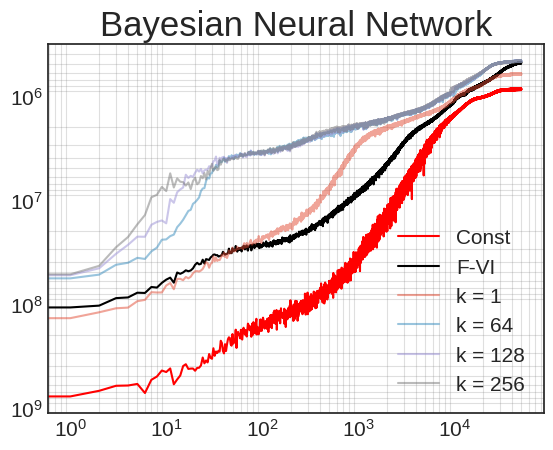

In [897]:
fig, ax =  plt.subplots()
plotted_widths = np.array([1, 4, 16])
n_width = len(nn_widths)

ax.plot(loss_all[:, n_width + 1], label = 'Const', color = 'red')
ax.plot(loss_all[:, n_width], label = 'F-VI', color = 'black')

for i in range(n_width):
    ax.plot(loss_all[:,i], label = "k = " + str(nn_widths[i]), alpha=0.5)

plt.yscale("log")
plt.xscale("log")
plt.legend(loc="best")
plt.grid(which = 'minor', visible = 'true', c = 'grey', alpha = 0.25)
plt.gca().invert_yaxis()
plt.title("Bayesian Neural Network")
# plt.xlabel("Iterations")
# plt.ylabel("Negative ELBO")
plt.savefig("to_discuss/elbo_BNN_" + str(seed) + ".pdf", bbox_inches='tight')
plt.show()

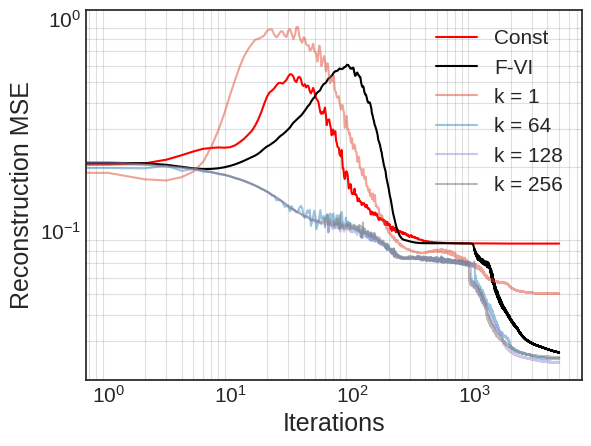

In [898]:
fig, ax =  plt.subplots()
plotted_widths = np.array([1, 4, 16])
n_width = len(nn_widths)

ax.plot(mse_all[:, n_width + 1], label = 'Const', color = 'red')
ax.plot(mse_all[:, n_width], label = 'F-VI', color = 'black')

for i in range(n_width):
    ax.plot(mse_all[:,i], label = "k = " + str(nn_widths[i]), alpha=0.5)

plt.yscale("log")
plt.xscale("log")
plt.legend(loc="best")
plt.grid(which = 'minor', visible = 'true', c = 'grey', alpha = 0.25)
# plt.title("Bayesian Neural Network")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction MSE")

plt.savefig("to_discuss/mse_BNN_" + str(seed) + ".pdf", bbox_inches='tight')

plt.show()

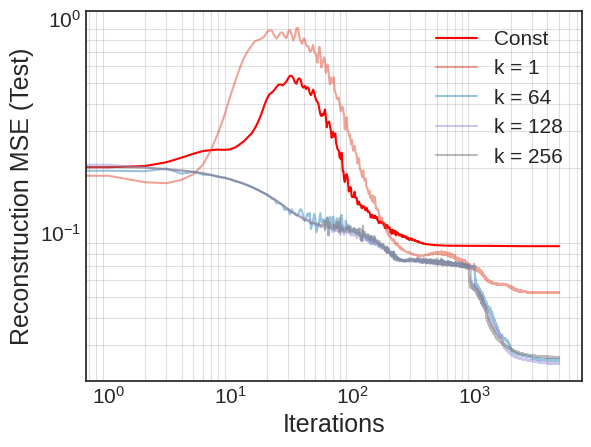

In [899]:
fig, ax =  plt.subplots()
plotted_widths = np.array([1, 4, 16])
n_width = len(nn_widths)

ax.plot(mse_test_all[:, n_width + 1], label = 'Const', color = 'red')
# ax.plot(mse_all[:, n_width], label = 'F-VI', color = 'black')

for i in range(n_width):
    ax.plot(mse_test_all[:,i], label = "k = " + str(nn_widths[i]), alpha=0.5)

plt.yscale("log")
plt.xscale("log")
plt.legend(loc="best")
plt.grid(which = 'minor', visible = 'true', c = 'grey', alpha = 0.25)
# plt.title("Bayesian Neural Network")
plt.xlabel("Iterations")
plt.ylabel("Reconstruction MSE (Test)")

plt.savefig("to_discuss/mse_test_BNN_" + str(seed) + ".pdf", bbox_inches='tight')

plt.show()

Next, analyze results across seeds.

In [872]:
def Iter_to_tol(mse, tol, grid=1, min_epoch=0, max_epoch=5000):
    iteration = min_epoch
    error = tol + 1
    while (error > tol and iteration < (max_epoch - 1)):
        iteration += grid
        error = mse[iteration]

    return iteration


In [883]:
# Get results across multiple seeds 
init_seed = 1789
num_seed = 10
n_algorithms = 6
tol = 0.03

exp_seed = [1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1954]

iter_to_tol = np.empty((num_seed, n_algorithms))
mse_final = np.empty((num_seed, n_algorithms))

for i in range(num_seed):
    mse_all = np.load("deliv_BVAE/vae_" + data_set + "_mse_" + str(exp_seed[i]) + ".npy")

    for j in range(n_algorithms):
        iter_to_tol[i, j] = Iter_to_tol(mse_all[:, j], tol=tol)
        mse_final[i, j] = mse_all[-1, j]





In [889]:
iter_to_tol

array([[2853., 4999., 4999., 1743., 1801., 1648.],
       [2727., 4999., 4999., 1790., 1757., 1644.],
       [2705., 4999., 4999., 1834., 1558., 1761.],
       [2735., 4999., 4999., 2015., 1812., 1732.],
       [2676., 4999., 4999., 1748., 1813., 1792.],
       [2748., 4999., 4999., 1829., 1818., 1637.],
       [2652., 4999., 4999., 1813., 1692., 1706.],
       [2910., 4999., 4999., 1865., 1680., 1615.],
       [2694., 4999., 4999., 1771., 1657., 1815.],
       [2782., 4999., 4999., 1943., 1726., 1720.]])

In [888]:
# swap columns to have F-VI and const appear first.
iter_to_tol = iter_to_tol[:, [4, 5, 0, 1, 2, 3]]
iter_to_tol_flat = np.transpose(iter_to_tol).reshape(num_seed * n_algorithms)

In [890]:
algo_names = np.array("F-VI")
algo_names = np.append(algo_names, "const")
for i in range(n_algorithms - 2):
    algo_names = np.append(algo_names, "k=" + str(nn_widths[i]))

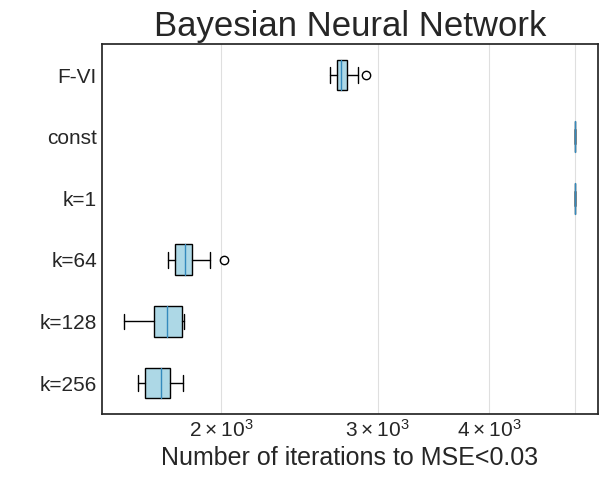

In [895]:
plt.boxplot(iter_to_tol, labels=algo_names, patch_artist=True,
             boxprops = dict(facecolor = "lightblue"), vert=False
             )
plt.xscale("log")
plt.grid(which='minor', visible='true', c='grey', alpha = 0.25)
# plt.xticks(rotation=45)
plt.gca().invert_yaxis()

plt.title("Bayesian Neural Network")
plt.ylabel(" ")
plt.xlabel("Number of iterations to MSE<0.03")

plt.savefig("to_discuss/conv_BNN_boxplot.pdf", bbox_inches='tight')
plt.show()


# Draft code

In [800]:
z_dim = 64
like_dim = 256
n_epochs = 10
seed = 1954
lr = 1e-3

In [805]:
torch.manual_seed(1954)
model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, hidden_dim = 0,
                mc_samples = 1).to(device)
model, loss_saved, run_time, fvi_grad, mse_saved, _ =\
        run_vi(seed, model, x, n_epochs, n_obs, batch_size,
               print_output = True, lr = 1e-3, save_mse=True)


Starting training VAE...
	Epoch: 0 	loss:  tensor(63094020., device='cuda:0')
	MSE: 0.20865343511104584


In [ ]:
torch.manual_seed(1989)
hidden_dim = 256
model_avi = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = hidden_dim,
                      mc_samples = 1).to(device)
model_avi, loss_avi_saved, run_time, fvi_grad, mse_saved_avi, mse_saved_avi_test =\
        run_vi(seed, model_avi, x, n_epochs, n_obs, batch_size, print_output = True, lr = 1e-3,
               save_mse=True, save_mse_test=True, x_test=x_test)

In [ ]:
torch.manual_seed(1989)
hidden_dim = 1
model_avi2 = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = hidden_dim,
                      mc_samples = 1).to(device)
model_avi2, loss_avi_saved2, run_time, fvi_grad, mse_saved_avi2, mse_saved_avi_test2 =\
        run_vi(seed, model_avi2, x, n_epochs, n_obs, batch_size, print_output = True, lr = 1e-3,
               save_mse=True, save_mse_test=True, x_test=x_test)

###  DRAFT: Run numerical experiments
These are the numerical experiments for the previous version of the manuscript. They have been replaced with the experiments above.

In [18]:
def run_experiment(seed, data_set, n_epochs, nn_widths, lr):
    # NOTE: the seed is used (i) when initializing the model, and (ii) when running the
    # optimizer.

    loss_all = np.empty((n_epochs, 3 + nn_widths.size))
    saved_times = np.empty(3 + nn_widths.size)
    saved_fvi_gradient = np.empty(3 + nn_widths.size)

    # Run F-VI
    torch.manual_seed(seed)
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
    loss_all[:, 0] = loss
    saved_times[0] = time_s
    saved_fvi_gradient[0] = fvi_gradient.data

    # Run A-VI
    for i in range(nn_widths.size):
        print("\tRunning widths = ", nn_widths[i])
        torch.manual_seed(seed)
        model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True,
                      hidden_dim = nn_widths[i]).to(device)
        _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
        loss_all[:, i + 1] = loss
        saved_times[i + 1] = time_s
        saved_fvi_gradient[i + 1] = fvi_gradient.data

        if (i == 0):
            best_loss = loss_all[n_epochs - 1, i + 1]
            model_best = _model
        elif (loss_all[n_epochs - 1, i + 1] <= best_loss):
            best_loss = loss_all[n_epochs - 1, i + 1]
            model_best = _model
    
    # Run F-VI with an initialization provided by A-VI (k = 100)
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model_best.variational_parameters(x)
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False,
                  init_z = True, nu_mean_z_init = nu_mean_z,
                  nu_sd_z_log_init = nu_sd_z_log,
                  init_theta = True, nu_mean_theta_init = nu_mean_theta,
                  nu_sd_theta_log_init = nu_sd_theta_log).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
    loss_all[:, nn_widths.size + 1] = loss
    saved_times[nn_widths.size + 1] = time_s
    saved_fvi_gradient[nn_widths.size + 1] = fvi_gradient.data

    # Run A-VI with constant out for inference network
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, const_z = True).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output=False, lr=lr)
    loss_all[:, nn_widths.size + 2] = loss
    saved_times[nn_widths.size + 2] = time_s
    saved_fvi_gradient[nn_widths.size + 2] = fvi_gradient.data

    np.save("deliv/vae_" + data_set + "_loss_" + str(seed), loss_all)
    np.save("deliv/vae_" + data_set + "_time_" + str(seed), saved_times)
    np.save("deliv/fvi_" + data_set + "_gradient_" + str(seed), saved_times)


In [19]:
# nn_widths = np.array([1, 10, 40, 80, 100, 120])
nn_widths = np.array([1, 10, 20, 40, 80, 120])
n_epochs = 500  # 2000 (1000 might be enough)
# lr = 1e-5

# run_experiment(seed, data_set, n_epochs, nn_widths, lr)


In [20]:
lr = 1e-4  # for A-VI on CIFAR10, may require a smaller learning rate.
init_seed = 1954
for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, data_set, n_epochs, nn_widths, lr)

seed:  1954
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1955
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1956
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1957
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1958
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1959
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1960
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths

### DRAFT: Read in and analyze experimental results

In [39]:
n_epochs = 500
nn_widths = np.array([1, 10, 20, 40, 80, 120])

In [40]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)])

window = 10
index_center = n_epochs - window

In [41]:
# Get results across multiple seeds
# For FashionMNIST, init_seed is 1789
# For MNIST, init_seed is 1954
# For CIFAR10, init_seed is 1963

data_set = "FashionMNIST"
init_seed = 1789
num_seed = 10
num_algorithms = nn_widths.size + 3
n_epochs = 500

Elbo_final = np.empty((num_seed, num_algorithms))

for i in range(num_seed):
    loss_all = np.load("deliv/vae_" + data_set + "_loss_" + str(init_seed + i) + ".npy")

    for j in range(num_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:,j], n_epochs - window, window)

# Get the best (non-nan) Elbo estimate obtained with 
Elbo_silver = - np.nanmin(Elbo_final[:, nn_widths.size + 1])

# Get the optimal Elbo returned by all algorithms
Elbo_max = - np.nanmin(Elbo_final, axis = 0)
print("Elbo max: ", Elbo_max)

print("Elbo silver: ", Elbo_silver)


Elbo max:  [5.04399973e+17 1.01117661e+18 6.02057902e+17 2.94839370e+18
 4.15585126e+18 9.22298583e+18 6.64609740e+18 1.98181110e+19
 9.65803873e+14]
Elbo silver:  1.9818110995989213e+19


In [42]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 15, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 2


/tmp/ipykernel_3493474/1543660394.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


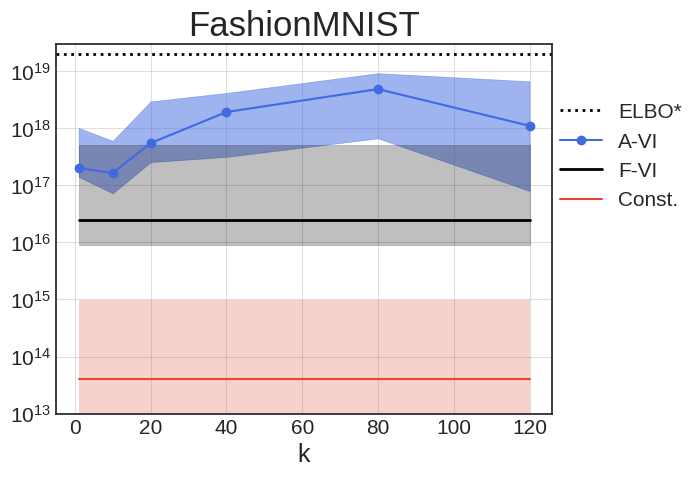

In [43]:
Elbo_median = - np.nanmedian(Elbo_final, axis = 0)
Elbo_min = - np.nanmax(Elbo_final, axis = 0)

linewidth = 2

plt.axhline(y = Elbo_silver, linewidth = linewidth, color = 'black', linestyle = "dotted",
           label = "ELBO*")

plt.plot(nn_widths, Elbo_median[1:7], "-o", label = "A-VI", color = "royalblue")
plt.fill_between(nn_widths, Elbo_max[1:7], Elbo_min[1:7], alpha = 0.5, color = "royalblue")

plt.plot(nn_widths, np.repeat(Elbo_median[0], 6), linewidth = linewidth, color = 'black', label = "F-VI")
plt.fill_between(nn_widths, np.repeat(Elbo_min[0], 6), np.repeat(Elbo_max[0], 6), alpha = 0.25,
                 color = "black")

plot_constant = True

if(plot_constant):
    plt.plot(nn_widths, np.repeat(Elbo_median[8], 6), label = "Const.")
    plt.fill_between(nn_widths, Elbo_max[8], Elbo_min[8], alpha = 0.25)

plt.yscale("log")
plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)
plt.xlabel("k")
if (data_set == "MNIST"):
    plt.ylabel("ELBO")
plt.title(data_set)
if (data_set == "FashionMNIST"):
    plt.legend(loc = "lower right", bbox_to_anchor=(1.3, 0.5))
    plt.ylim(1e13, 3e19)


plt.savefig("to_discuss/k_vae_" + data_set + ".pdf", bbox_inches = 'tight')


In [44]:
# Examine a specific seed for example plot
seed = 1968
data_set = "FashionMNIST"  # Options: MNIST, FashionMNIST, CIRFAR10
loss_all = np.load("deliv/vae_" + data_set + "_loss_" + str(seed) + ".npy")


In [ ]:

fig, ax = plt.subplots()
plotted_widths = np.array([10, 40, 80])
# nn_widths = np.array([1, 10, 20, 40, 80, 120])

n_start = 0

# ax.plot(- loss_all[n_start:, nn_widths.size + 1], label = "AF-VI", color = 'black',
#         linestyle = "dashed", linewidth = linewidth)

ax.axhline(y = Elbo_silver, linewidth = linewidth, color = 'black', linestyle = "dotted",
           label = "ELBO*")

ax.plot(-loss_all[n_start:, 0], label = 'F-VI', linewidth = linewidth, color = 'black')


ax.plot(-loss_all[n_start:, nn_widths.size + 2], label = "Const", color = "red",
        linewidth = linewidth)

nn_widths = np.array([1, 10, 20, 40, 80, 120])
for i in range(nn_widths.size):
    if (nn_widths[i] in plotted_widths):
        ax.plot(- loss_all[n_start:, i + 1], label = "k = " + str(nn_widths[i]), alpha = 0.5,
        linewidth = linewidth)

plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)
plt.legend(loc = "lower right", ncols = 2, bbox_to_anchor=(1.025, -0.04))
# plt.ylim(10**1, 1 * 10**19)
plt.yscale("log")
plt.title("VAE " + data_set)

plt.savefig("to_discuss/elbo_vae_" + data_set + "_" + str(seed) + ".pdf", bbox_inches = 'tight')
plt.show()


In [97]:
# Get asymptotic ELBO
print("Silver: ", mean_window(loss_all[:, nn_widths.size + 1], index_center, window), " +/- ",
      sd_window(loss_all[:, nn_widths.size + 1], index_center, window))

print("FVI: ", mean_window(loss_all[:, 0], index_center, window), " +/- ",
      sd_window(loss_all[:, 0], index_center, window))

print("Const: ", mean_window(loss_all[:, nn_widths.size + 2], index_center, window), " +/- ",
      sd_window(loss_all[:, nn_widths.size + 2], index_center, window))

for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ", mean_window(loss_all[:, i + 1],
        index_center, window), " +/- ",
        sd_window(loss_all[:, i], index_center, window))


Silver:  -1.916481070865192e+19  +/-  1.3551668232630513e+18
FVI:  -1.4343688474979206e+16  +/-  8321339449737356.0
Const:  -965815298403860.5  +/-  1389057317300.9983
k = 1:  -4.4422675871549094e+17  +/-  8321339449737356.0
k = 10:  -1.736477394706891e+17  +/-  3.778198812129833e+16
k = 20:  -2.6109344666148144e+17  +/-  1.921753083796226e+16
k = 40:  -8.440083323917487e+17  +/-  3.859208973807375e+16
k = 80:  -7.530952081576905e+18  +/-  7.869393942158878e+16
k = 120:  -6.128665710349181e+18  +/-  1.0217704987858893e+18
